# Neural Network Model, Trained on Global Dataset

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-11 18:43:15.554582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
global_model_path = '/home/julias/MLEE-final-project/models/saved_models/global_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

Added a time slice for only the most recent available decade, to reduce data processing burden

In [61]:
slice_time_start = '2007'

X_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))
y_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))
X_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))
y_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))
X_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))
y_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').sel(time=slice(slice_time_start,None))

In [62]:
# X_ds.SSS.max()

In [63]:
X_df = X_ds.to_dataframe().dropna()
y_df = y_ds.to_dataframe().dropna()
X_train_df = X_train_ds.to_dataframe().dropna()
y_train_df = y_train_ds.to_dataframe().dropna()
X_test_df = X_test_ds.to_dataframe().dropna()
y_test_df = y_test_ds.to_dataframe().dropna()

In [64]:
X_train_df

SSS       SST         MLD       Chl  \
xlon   ylat  time                                                    
-179.5 -77.5 2007-01-15  34.417393  1.127747   12.827788  6.294212   
             2007-03-15  33.951885  0.158896   36.233391  0.717178   
             2007-04-15  34.073288 -1.773473   55.796215  0.120345   
             2007-05-15  34.406742 -1.823258  133.223541  0.068951   
             2007-06-15  34.501469 -1.805117  367.266876  0.023162   
...                            ...       ...         ...       ...   
 179.5  62.5 2016-08-15  31.746555  7.662945   11.816436  2.494927   
             2016-10-15  32.134586  8.096124   14.649062  3.452075   
             2016-11-15  32.348038  3.943792   21.109644  3.294265   
             2016-12-15  32.432415  1.491198   23.901501  0.676724   
             2017-01-15  32.546829 -0.784372   24.382210  0.089501   

                               XCO2        T0        T1         A         B  \
xlon   ylat  time                                                             
-179.5 -77.5 2007-01-15  382.689117  0.966848  0.255353 -0.976296 -0.001889   
             2007-03-15  383.021515  0.292600  0.956235 -0.976296 -0.001889   
             2007-04-15  383.185120 -0.234491  0.972118 -0.976296 -0.001889   
             2007-05-15  383.354034 -0.683919  0.729558 -0.976296 -0.001889   
             2007-06-15  383.522949 -0.959933  0.280231 -0.976296 -0.001889   
...                             ...       ...       ...       ...       ...   
 179.5  62.5 2016-08-15  405.810944 -0.708627 -0.705584  0.887011  0.004029   
             2016-10-15  406.276947  0.259512 -0.965740  0.887011  0.004029   
             2016-11-15  406.508392  0.714673 -0.699458  0.887011  0.004029   
             2016-12-15  406.739502  0.966848 -0.255353  0.887011  0.004029   
             2017-01-15  406.971283  0.966848  0.255353  0.887011  0.004029   

                                C  
xlon   ylat  time                  
-179.5 -77.5 2007-01-15  0.216431  
             2007-03-15  0.216431  
             2007-04-15  0.216431  
             2007-05-15  0.216431  
             2007-06-15  0.216431  
...                           ...  
 179.5  62.5 2016-08-15  0.461731  
             2016-10-15  0.461731  
             2016-11-15  0.461731  
             2016-12-15  0.461731  
             2017-01-15  0.461731  

[3425482 rows x 10 columns]

# Simple NN Model

## Build NN Model

In [ ]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [70]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.0005
minibatch_size = 64
model_num      = 1

In [71]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [72]:
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [74]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = NN_model.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.3, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
37467/37467 [==============================] - 56s 1ms/step - loss: 420.6571 - val_loss: 480.2146
Epoch 2/50
37467/37467 [==============================] - 55s 1ms/step - loss: 278.1484 - val_loss: 451.2150
Epoch 3/50
37467/37467 [==============================] - 56s 1ms/step - loss: 213.0636 - val_loss: 421.4594
Epoch 4/50
37467/37467 [==============================] - 54s 1ms/step - loss: 174.8409 - val_loss: 409.3401
Epoch 5/50
37467/37467 [==============================] - 55s 1ms/step - loss: 155.1775 - val_loss: 392.1204
Epoch 6/50
37467/37467 [==============================] - 55s 1ms/step - loss: 143.1530 - val_loss: 411.3730
Epoch 7/50
37467/37467 [==============================] - 55s 1ms/step - loss: 134.3700 - val_loss: 436.8810
Epoch 8/50
37467/37467 [==============================] - 55s 1ms/step - loss: 128.2520 - val_loss: 394.2390
Epoch 9/50
37467/37467 [==============================] - 56s 2ms/step - loss: 122.7942 - val_loss: 403.0635
Epoch 10/50
37467/3

## Initial Checks

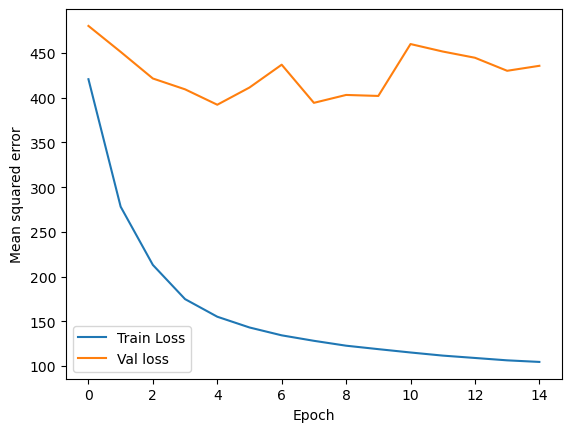

In [75]:
model_utils.plot_history(history)

Validation loss does jump around and is generally higher than the training loss, indicating that the model isn't generalizing well

## Save NN Model

In [76]:
# after training, save:
NN_model.save(os.path.join(global_model_path,'NN_model_prelim_reducedglobal.h5'))

## Test NN Model

In [77]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(global_model_path,'NN_model_prelim_reducedglobal.h5'))

In [78]:
y_pred = NN_prelim_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse)

26486/26486 [==============================] - 17s 654us/step
MSE: 203.20


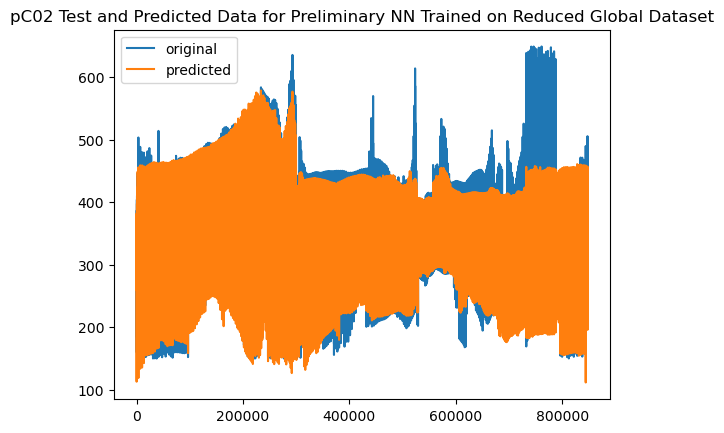

In [80]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN Trained on Reduced Global Dataset")
plt.legend()
plt.show()

In [ ]:
#y_test_df_norm['y_pred']= y_pred
#save_prelim_y_pred = y_test_df_norm
#save_prelim_y_pred.to_csv('/home/julias/MLEE-final-project/models/saved_models/global_models/save_prelim_y_pred.csv')

# NN Model using Hyperparameters from Limited Dataset Training

## Build NN Model

Notice that in preliminary runs, validation loss didn't go down with training loss. 
- To try to address this issue, will increase validation split to 70/30 (as opposed to 80% training 20% validation)
- Training loss is also starting low (and then staying low), signaling that I may be overfitting to the training set. I'll try to reduce the neurons and remove a hidden layer to see if that improves performance. 
   - *(I'd rather run for more epochs and watch training/validation losses decrease together than minimize training loss and maintain a constant validation loss.)*

In [87]:
# from run on non-global dataset:
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005 
#minibatch_size = 100
#model_num      = 1

#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# three hidden layers

# Stopped prematurely, training loss: 99.0619 - val_loss: 580.4343 and val clearly not decreasing
# Change hyperparameters to prevent overfitting **Revisited later, with val training split adjusted back to 80/20

In [ ]:
#n_neuron       = 100
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.0001
#minibatch_size = 100
#model_num      = 1

#two hidden layers

#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# better alignment at first but at epoch 20, training loss at 270 and val loss back up to 670

In [116]:
n_neuron       = 20
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.0005
minibatch_size = 100
model_num      = 1

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [117]:
NN_model1 = Sequential()

NN_model1.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model1.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model1.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
#NN_model1.add(Dense(n_neuron, name='hidden_layer_4', activation=activation))
#NN_model1.add(Dense(n_neuron, name='hidden_layer_5', activation=activation))
NN_model1.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [118]:
NN_model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 20)                220       
                                                                 
 hidden_layer_2 (Dense)      (None, 20)                420       
                                                                 
 hidden_layer_3 (Dense)      (None, 20)                420       
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


In [119]:
history1 = NN_model1.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.3, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/100
23979/23979 [==============================] - 30s 1ms/step - loss: 1175.9479 - val_loss: 637.9985
Epoch 2/100
23979/23979 [==============================] - 29s 1ms/step - loss: 568.7838 - val_loss: 709.6919
Epoch 3/100
23979/23979 [==============================] - 29s 1ms/step - loss: 511.5018 - val_loss: 567.4974
Epoch 4/100
23979/23979 [==============================] - 28s 1ms/step - loss: 438.1147 - val_loss: 536.2598
Epoch 5/100
23979/23979 [==============================] - 31s 1ms/step - loss: 401.2714 - val_loss: 483.5031
Epoch 6/100
23979/23979 [==============================] - 28s 1ms/step - loss: 370.1837 - val_loss: 536.4839
Epoch 7/100
23979/23979 [==============================] - 31s 1ms/step - loss: 342.0744 - val_loss: 547.6198
Epoch 8/100
23979/23979 [==============================] - 29s 1ms/step - loss: 316.7307 - val_loss: 515.9301
Epoch 9/100
23979/23979 [==============================] - 29s 1ms/step - loss: 298.9570 - val_loss: 481.1322
Epoch 10/

## Initial Checks

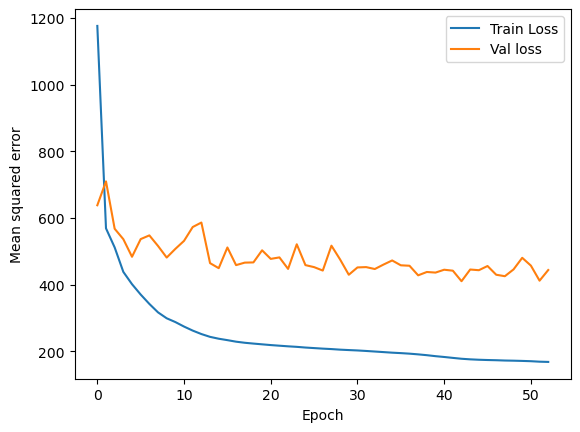

In [120]:
model_utils.plot_history(history1)

Validation loss does jump around and is generally higher than the training loss, indicating that the model isn't generalizing well

## Save NN Model

In [122]:
# after training, save:
NN_model1.save(os.path.join(global_model_path,'NN_model_prelim_alternate.h5'))

# NN Model Optimization: Scaled Down NN

Validation loss not going down with training loss. 
- Now that reduced dataset, maybe need to go back to 80/20 training/validation split

## Build NN Model

In [164]:
# set hyperparameters
n_neuron       = 50
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.0005
minibatch_size = 200
model_num      = 1

In [165]:
NN_model2 = Sequential()

NN_model2.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model2.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model2.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
#NN_model2.add(Dense(n_neuron, name='hidden_layer_4', activation=activation))
#NN_model2.add(Dense(n_neuron, name='hidden_layer_5', activation=activation))
NN_model2.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [166]:
NN_model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 50)                550       
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                2550      
                                                                 
 hidden_layer_3 (Dense)      (None, 50)                2550      
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [168]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history2 = NN_model2.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/100
13702/13702 [==============================] - 22s 2ms/step - loss: 400.2588 - val_loss: 526.4052
Epoch 2/100
13702/13702 [==============================] - 23s 2ms/step - loss: 318.6541 - val_loss: 394.9890
Epoch 3/100
13702/13702 [==============================] - 23s 2ms/step - loss: 286.1823 - val_loss: 372.3893
Epoch 4/100
13702/13702 [==============================] - 23s 2ms/step - loss: 260.4237 - val_loss: 327.0813
Epoch 5/100
13702/13702 [==============================] - 23s 2ms/step - loss: 240.8829 - val_loss: 316.7254
Epoch 6/100
13702/13702 [==============================] - 25s 2ms/step - loss: 226.6932 - val_loss: 316.4193
Epoch 7/100
13702/13702 [==============================] - 23s 2ms/step - loss: 213.9219 - val_loss: 304.9968
Epoch 8/100
13702/13702 [==============================] - 21s 2ms/step - loss: 201.6681 - val_loss: 311.9753
Epoch 9/100
13702/13702 [==============================] - 21s 2ms/step - loss: 189.1061 - val_loss: 294.0602
Epoch 10/1

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

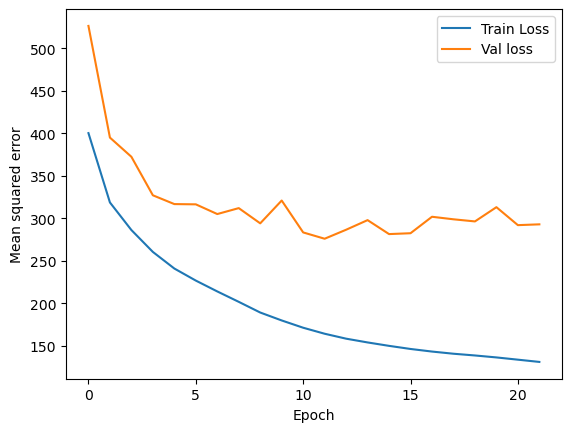

In [200]:
model_utils.plot_history(history2)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

## Save NN Model

In [170]:
# after training, save:
NN_model2.save(os.path.join(global_model_path,'NN_model_semioptimized.h5'))

## Test NN Model

In [197]:
NN_model_semioptimized = load_model(os.path.join(global_model_path,'NN_model_semioptimized.h5'))

In [204]:
y_pred_semioptimized = NN_model_semioptimized.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_semioptimized)
print("MSE: %.2f" % mse)

26486/26486 [==============================] - 17s 625us/step
MSE: 196.92


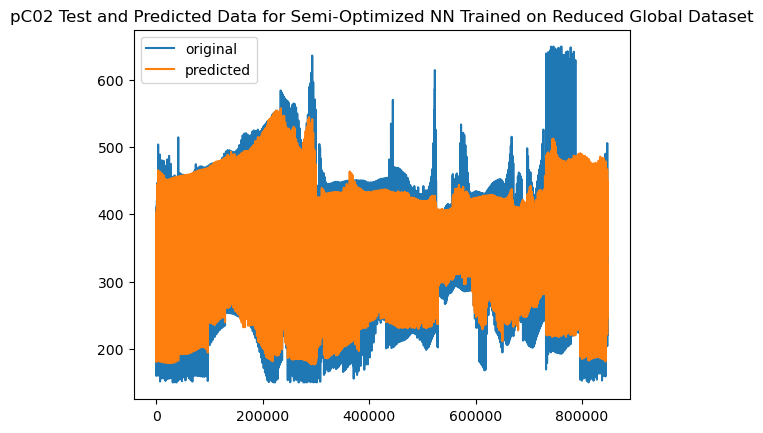

In [205]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_semioptimized, label="predicted")
plt.title("pC02 Test and Predicted Data for Semi-Optimized NN Trained on Reduced Global Dataset")
plt.legend()
plt.show()

# NN Model Further Optimization

## Build NN Model

In [190]:
# set hyperparameters
#n_neuron       = 100 #tried 50
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005 #tried 0.001,0.0001
#minibatch_size = 100 #tried 200
#model_num      = 1

In [191]:
#NN_model3 = Sequential()

#NN_model3.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
#NN_model3.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
#NN_model3.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
#NN_model3.add(Dense(1, name='output_layer', activation='linear')) # the output layer


#NN_model3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [192]:
#NN_model3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1100      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [ ]:
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


#history3 = NN_model3.fit(X_train_df, y_train_df, 
#                            batch_size      = minibatch_size,
#                            epochs          = num_epochs,
#                            validation_split= 0.2, 
#                            verbose         = 1,
#                            callbacks       = [early_stop])

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

In [ ]:
model_utils.plot_history(history3)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

## Save NN Model

In [ ]:
# after training, save:
NN_model3.save(os.path.join(global_model_path,'NN_model_furtheroptimized.h5'))

## Test NN Model

In [ ]:
NN_model_furtheroptimized = load_model(os.path.join(global_model_path,'NN_model_furtheroptimized.h5'))

In [ ]:
y_pred__furtheroptimized = NN_model_furtheroptimized.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred__furtheroptimized)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred__furtheroptimized, label="predicted")
plt.title("pC02 Test and Predicted Data for Further Optimized NN Trained on Reduced Global Dataset")
plt.legend()
plt.show()

# Analysis

In [207]:
y_test_df['pred_pCO2'] = y_pred_semioptimized
y_comparison = y_test_df.to_xarray().transpose('time','ylat','xlon')

Text(0.5, 1.0, 'pC02 Predicted Data in September 2016')

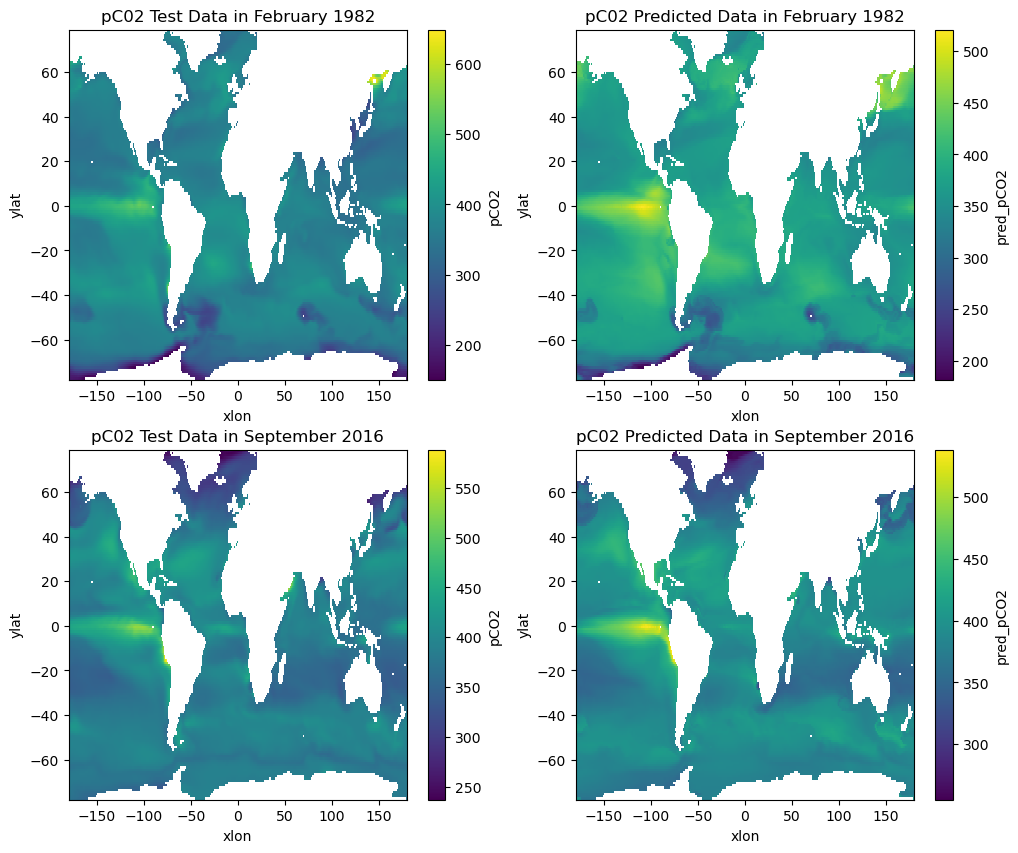

In [208]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(12,10))

y_comparison.pCO2[0,:,:].plot(ax=ax1)
ax1.set_title('pC02 Test Data in February 1982')

y_comparison.pred_pCO2[0,:,:].plot(ax=ax2)
ax2.set_title('pC02 Predicted Data in February 1982')

y_comparison.sel(time='2016-9-15').pCO2.plot(ax=ax3)
ax3.set_title('pC02 Test Data in September 2016')

y_comparison.sel(time='2016-9-15').pred_pCO2.plot(ax=ax4)
ax4.set_title('pC02 Predicted Data in September 2016')